## Concepts Explored in this notebook
I first started with breaking the process apart; infer angles and velocities from coordinates, then infer torques from angular data. It turned out that you can infer the full model properly with enough independent SMC samplers.
1. simulate data from full model - `Transition_Short` + `Emission`.
2. pre-process: infer using - `Transition_Velocity` + `Emission` + `Bootstrap_Proposal`.
3. take the mean infered states $\mathbf{x} \in \mathbb{R}^4$ as observations, and infer using `Transition_Short` + `Emission_Linear` + 'Optimal_Proposal`.

In [1]:
import os
print(os.getcwd())
plot_folder = 'planar_arm_dyn_plots'

/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test


In [2]:
# change dir to import from aesmc
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc")
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state
import aesmc.math as math

In [3]:
# change dir to import from aesmc/test
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test")
from arm_models import planar_arm_dyn_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # make video, plot post, params to coords
from arm_models import utils_summary
from arm_models import fw_sim_planar_arm_dyn

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [5]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

In [7]:
import pickle

# pickle utils
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as input:  # note rb and not wb
        return pickle.load(input)

In [8]:
def sim_data_from_model(model_dict, num_timesteps, batch_size, repeat_data):
    '''this utility just allows to pass a model_dict with
    "initial", "transition", and "emission" objects.'''
    sim_lats, sim_observs = statistics.sample_from_prior(
        model_dict["initial"], model_dict["transition"],
        model_dict["emission"], num_timesteps, batch_size, repeat_data)
    return sim_lats, sim_observs

In [9]:
def infer_latents(model_dict, observations, num_particles):
    """wrapper around aesmc.inference.infer that allows to input a model_dict
    with the four distribution objects. note, currently 
    Args: 
        model_dict: [dict] with initial, transition, emission, and proposal
        observations: [list] of length num_timepoints with each entry a tensor
        torch.Size(batch_size, dim_obs)
        num_particles: [int]
    Returns:
        list with latents, log_weights, etc."""
    import time as time
    start_time_fw = time.time()
    inference_result = inference.infer(
        inference_algorithm='smc',
        observations=observations,
        initial=model_dict["initial"],
        transition=model_dict["transition"],
        emission=model_dict["emission"],
        proposal=model_dict["proposal"],
        num_particles=num_particles,
        return_log_weights=True,
        return_log_marginal_likelihood=True,
    )
    print('run time for %i timesteps, %i batches, %i particles = %.2f' % \
      (len(observations), observations[-1].shape[0],
       num_particles, time.time() - start_time_fw))
    return inference_result

In [10]:
def plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict,
                       fig_full_path):
    plt.subplot(121)
    plt.plot(lat_data_np[ind_in_batch, :, :].T)
    plt.title('simulated states')
    plt.ylabel('variable values')
    plt.xlabel('time / dt')
    plt.legend(label_dict["state"])
    plt.subplot(122)
    plt.plot(sim_data_np[ind_in_batch, :, :].T)
    plt.title('simulated observations')
    plt.ylabel('variable values')
    plt.xlabel('time / dt')
    plt.legend(label_dict["obs"])
    plt.tight_layout()
    plt.savefig(fig_full_path)

In [11]:
def plot_inferred_traces_single_run(posterior_summary, lat_data_np, label_list,
                         ind_in_batch, fig_full_path):
    """wrapper around arm_utils.plot_posterior_trace
    ToDo: consider changing the image dims as a func of num_latents"""
    nrows = 2
    num_latents = lat_data_np.shape[1]
    fig, axs = plt.subplots(nrows,
                            int(num_latents / nrows),
                            figsize=(12, 9),
                            sharey=False)
    axs = axs.flatten()
    plt_leg = False
    for i in range(posterior_summary["smooth_mean"].shape[1]):
        if i == num_latents-1:
            plt_leg = True
        arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
    fig.tight_layout()
    plt.savefig(fig_full_path)

In [12]:
def plot_inferred_traces(post_mean, post_var, lat_data_np, label_list,
                         ind_in_batch, fig_full_path):
    """wrapper around arm_utils.plot_posterior_trace
    ToDo: consider changing the image dims as a func of num_latents"""
    nrows = 2
    num_latents = lat_data_np.shape[1]
    fig, axs = plt.subplots(nrows,
                            int(num_latents / nrows),
                            figsize=(12, 9),
                            sharey=False)
    axs = axs.flatten()
    plt_leg = False
    for i in range(posterior_summary["smooth_mean"].shape[1]):
        if i == num_latents-1:
            plt_leg = True
        arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
    fig.tight_layout()
    plt.savefig(fig_full_path)

In [13]:
# define global model params
dt = 0.03
g = 1.0
dim_latents = 6 # always 6 in this model.
dim_obs = 4
transition_force_scale = 20.0 # 20.0 was best; tried also 10, 30, 50
transition_aux_scale = ((dt**2)*transition_force_scale**2) / (10.0) #* 2
transition_velocity_scale = transition_force_scale # 20.0 was good for sanity check. used 5.0 for velocity model
initial_loc = 0.0
initial_scale = 0.5 # in future could be different per dimension.
emission_var_diag = 0.02 # was 0.1 before. this varies with the application. 
# it was working relatively well with 0.2 or 1.0 for linear case. but for the arm it's to big.
print('torque effective variance: %.5f' %((dt**2)*transition_force_scale**2))
print('auxilliary variance: %.5f' % transition_aux_scale)

torque effective variance: 0.36000
auxilliary variance: 0.03600


In [14]:
# put params into dicts
param_dict = {}
param_dict["init_mu"] = initial_loc * np.ones(dim_latents)
param_dict["init_cov"] = np.eye(dim_latents) * initial_scale
#param_dict["C"] = np.eye(dim_obs) # (1.0/6.0)*np.random.normal(size = (dim_obs,dim_latents))
param_dict["C"] = np.zeros(
    (dim_obs, dim_latents))  # not good, change, np.eye(dim_obs) #
print(type(param_dict["C"]))
param_dict["C"] = np.array(([[0, 0, 1.0, 0, 0, 0], [0, 0, 0, 1.0, 0, 0],
                             [0, 0, 0, 0, 1.0, 0], [0, 0, 0, 0, 0, 1.0]]))
print(param_dict["C"])
#param_dict["C"][0,2] = 1.0 # if select just a couple of states, config that here.
#param_dict["C"][1,3] = 1.0 # if select just a couple of states, config that here.
#param_dict["C"][2,4] = 1.0 # if select just a couple of states, config that here.
#param_dict["C"][3,5] = 1.0 # if select just a couple of states, config that here.
param_dict["R"] = np.diag([0.1,0.1,0.2,0.2]) # prev: #np.eye(dim_obs) * emission_var_diag
inits_dict = {}
inits_dict["L1"] = 2.0
inits_dict["L2"] = 2.0
inits_dict["M1"] = 1.1
inits_dict["M2"] = 1.2

<class 'numpy.ndarray'>
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [16]:
print(param_dict["R"])

[[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.2 0. ]
 [0.  0.  0.  0.2]]


In [17]:
# running params
num_timesteps = 200
saving_interval = 10
logging_interval = 10
batch_size = 16 # 64 good for independent SMC
num_iterations = 500
num_particles = 1000

In [18]:
# initialize arm model, used by transition and proposal.
arm_model_instance = planar_arm_dyn_model.PlanarArmDyn(dt, inits_dict, 
                                                       g, True, False)

In [19]:
full_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
we use it just to simulate ground truth data. 
with realistic data, we will start from the velocity inference model'''
full_model["initial"] = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])
full_model["transition"] = planar_arm_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_instance)
full_model["emission"] = planar_arm_dyn_model.Emission(
    inits_dict,
    np.eye(6) * emission_var_diag,
    theta_indices=[2,3])
full_model["proposal"] = planar_arm_dyn_model.Bootstrap_Proposal( \
                               full_model["initial"], full_model["transition"])

### Note - can choose proposal.
#### Bootstrap proposal:
`proposal = planar_arm_dyn_model.Bootstrap_Proposal_Short( \
                                initial, transition)`
#### Optimal proposal:
`proposal = planar_arm_dyn_model.Optimal_Proposal(initial, transition, emission)`

In [20]:
velocity_model = {}
"""velocity dynamics (no forces), FW-KIN emission
    since state is now 4-D, Initial should be 4D"""
velocity_model["initial"] = planar_arm_dyn_model.Initial(
    param_dict["init_mu"][:4], param_dict["init_cov"][:4, :4])
# ToDo: now using same scale parameters for velocity dynamics.
# could change.
velocity_model["transition"] = planar_arm_dyn_model.Transition_Velocity(
    dt, transition_velocity_scale, transition_aux_scale)
velocity_model["emission"] = planar_arm_dyn_model.Emission(
    inits_dict,
    np.eye(6) * emission_var_diag,
    theta_indices=[0,1])
velocity_model["proposal"] = planar_arm_dyn_model.Bootstrap_Proposal( \
                                velocity_model["initial"], velocity_model["transition"])

In [21]:
torque_model = {}
# ToDo: consider using observations to initialize properly.
torque_model["initial"] = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                                       param_dict["init_cov"])
torque_model["transition"] = planar_arm_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_instance)
torque_model["emission"] = planar_arm_dyn_model.Emission_Linear(
    param_dict["C"], param_dict["R"])
torque_model["proposal"] = planar_arm_dyn_model.Optimal_Proposal(
   torque_model["initial"], torque_model["transition"], torque_model["emission"])

In [22]:
# # simulate from torque model. 
# # that's working, basically the version that I had previously.
# sim_lats, sim_observs = sim_data_from_model(torque_model, num_timesteps,
#                                             batch_size)

## Step 1 (sanity check): simulate and infer the velocity dynamics model
Simulate coordinates from a latent velocity dynamics. Can we infer the true dynamics?

In [23]:
np.random.seed(0)
torch.manual_seed(0)

In [24]:
# no need for now.
full_model["transition"].arm_model.A = 1.0* torch.tensor([[-1,1],[-1,-1]], dtype = torch.double)
full_model["transition"].arm_model.A

tensor([[-1.,  1.],
        [-1., -1.]], dtype=torch.float64)

In [37]:
# simulate from velocity model.
# goal: only validate that we can infer that -- that's working.
sim_lats, sim_observs = sim_data_from_model(velocity_model, 
                                            num_timesteps,
                                            batch_size, True)

repeating data in batch.


In [38]:
# # if simulating from a deterministic model.
# sim_lats , sim_observs = fw_sim_planar_arm_dyn(
# sim_data(dt, num_timepoints, 
#                  param_dict, inits_dict, 
#                  sin_amp, sin_omega,
#                  sin_phase_diff, plot = True)  
# )
# print(sim_lats[-1].size()) # [batch_size, dim_latents]
# print(sim_observs[-1].size()) # [batch_size, dim_obs]

In [39]:
# concatenate and convert to numpy; for plotting.
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)
lat_data_np = lat_data.detach().numpy()
sim_data_np = sim_data.detach().numpy()

torch.Size([16, 4, 200])
torch.Size([16, 6, 200])


In [40]:
# Tailored for each simulated data set (how the latents and obs. look like)
label_dict_vel = {}
label_dict_vel["state"] = [r'$\theta_1$', r'$\theta_2$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']
label_dict_vel["obs"] = [r'$x_0$', r'$y_0$',
                     r'$x_1$', r'$y_1$',
                  r'$x_2$', r'$y_2$']
# ToDo: fill the dicts below.
label_dict_full = {}
label_dict_full["state"] = [r'$\tau_1$', r'$\tau_2$', 
              r'$\theta_1$', r'$\theta_2$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']
label_dict_full["obs"] = [r'$x_0$', r'$y_0$',
                     r'$x_1$', r'$y_1$',
                  r'$x_2$', r'$y_2$']
label_dict_torque = {}
label_dict_torque["state"] = [r'$\tau_1$', r'$\tau_2$', 
              r'$\theta_1$', r'$\theta_2$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']
label_dict_torque["obs"] = [r'$\theta_1$', r'$\theta_2$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']
# full state labels
# label_list = [r'$\tau_1$', r'$\tau_2$', 
#               r'$\theta_1$', r'$\theta_2$',
#              r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']

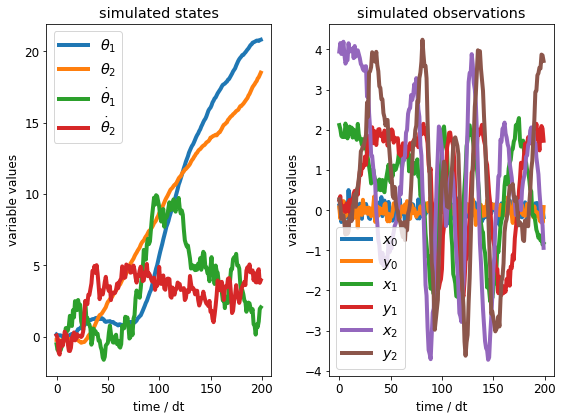

In [41]:
ind_in_batch = 8
plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict_vel,
                       plot_folder + '/sim_dataset.png')

In [42]:
inference_result = infer_latents(velocity_model, 
                                 sim_observs, 
                                 num_particles)

run time for 200 timesteps, 16 batches, 1000 particles = 12.90


In [43]:
# summarize each individual posterior
posterior_summary = utils_summary.summarize_posterior(inference_result)

In [54]:
def summarize_independent_smc_samplers(post_mean, post_var,
                                       logw=None,
                                       method='uniform',
                                       remove_indices=None):
    if remove_indices is not None:
        """helpful in the case that one estimate dominates the rest."""
        post_mean = np.delete(
           post_mean, remove_indices, axis=0)
        post_var = np.delete(
            post_var, remove_indices, axis=0)
        if logw is not None:
            logw = np.delete(logw, remove_indices)
    print('applying %s average of %i SMC samplers.' %
          (method, post_mean.shape[0]))
    if method == 'uniform':
        mean = np.mean(post_mean, axis=0)
        var = np.mean(post_var, axis=0)
    elif method == 'weighted':
        from scipy.special import logsumexp
        w = np.exp(logw - logsumexp(logw))
        mean = np.average(post_mean, axis=0, weights=w)
        var = np.average(post_var, axis=0, weights=w)
    else:
        print('method not supported. try weighted or uniform')
    return mean, var

applying uniform average of 16 SMC samplers.
applying weighted average of 16 SMC samplers.


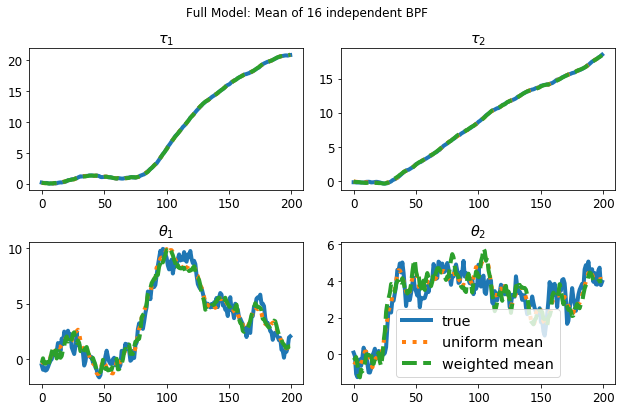

In [44]:
# comparison of
mean, var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=None,
    method='uniform')

weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None)

n_rows = 2
f, axarr = plt.subplots(n_rows, lat_data_np.shape[1] // n_rows, figsize=(9, 6))
axarr = axarr.flatten()
for i in range(lat_data_np.shape[1]):
    axarr[i].plot(lat_data_np[0, i, :], label='true')
    axarr[i].plot(mean[i, :], linestyle='dotted', label='uniform mean')
    axarr[i].plot(weighted_mean[i, :],
                  linestyle='dashed',
                  label='weighted mean')
    axarr[i].set_title(label_dict_full["state"][i])
    if i == lat_data_np.shape[1] - 1:
        plt.legend()
f.suptitle('Full Model: Mean of %i independent BPF' % batch_size)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(plot_folder + '/vel_model_sanity_check.png')

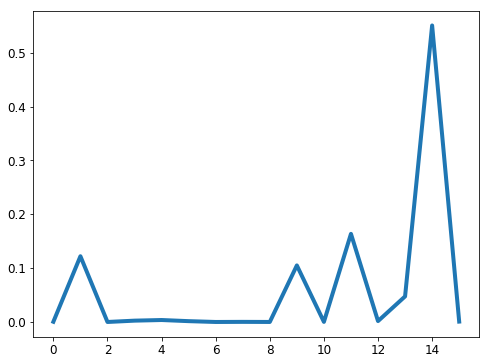

In [45]:
from scipy.special import logsumexp
logw = inference_result["log_marginal_likelihood"].detach().numpy()
w = np.exp(logw - logsumexp(logw))
plt.plot(w)

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


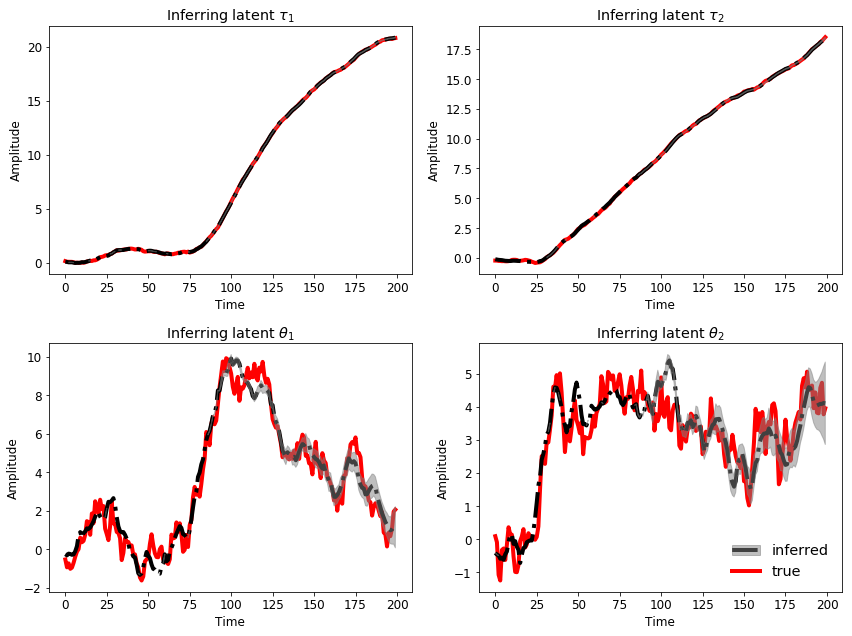

In [47]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/vel_sanity_check_uniform.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=mean[i,:],
    post_var=np.sqrt(var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


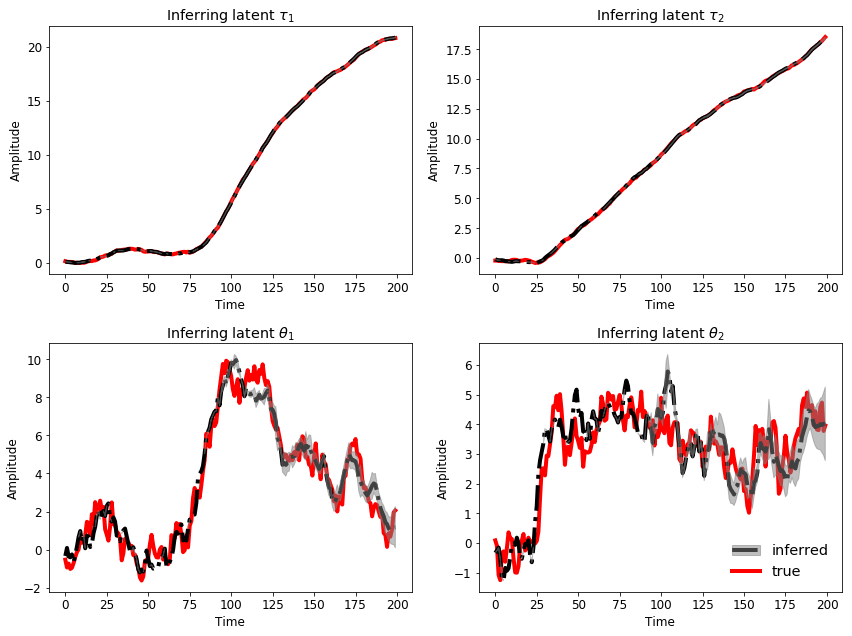

In [48]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/vel_sanity_weighted.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(weighted_mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=weighted_mean[i,:],
    post_var=np.sqrt(weighted_var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

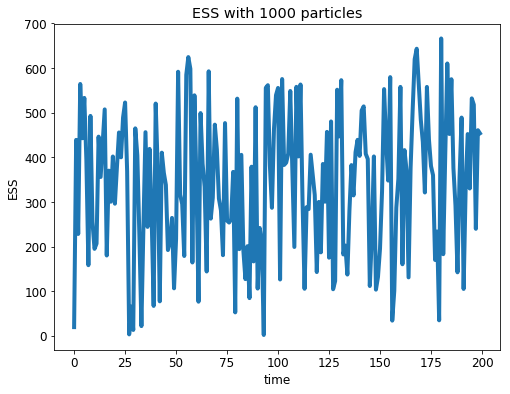

In [49]:
# plot ESS
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_1.png')

## Step 2: simulate data from full model and infer using velocity dynamics.

In [51]:
sim_lats, sim_observs = sim_data_from_model(full_model, num_timesteps,
                                            batch_size, True)

repeating data in batch.


In [52]:
# concatenate and convert to numpy; for plotting.
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)
lat_data_np = lat_data.detach().numpy()
sim_data_np = sim_data.detach().numpy()

torch.Size([16, 6, 200])
torch.Size([16, 6, 200])


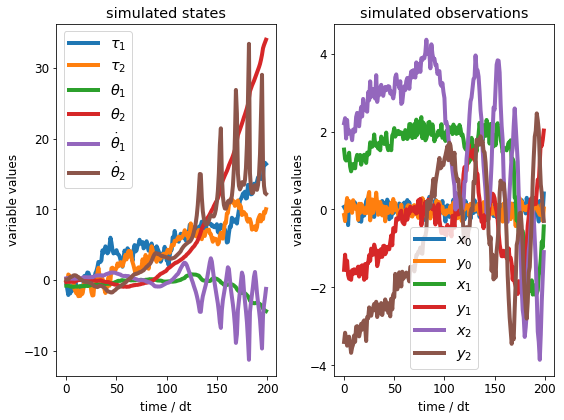

In [53]:
ind_in_batch = 8
plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict_full,
                       plot_folder + '/sim_dataset_full.png')

In [54]:
# infer using velocity model
inference_result = infer_latents(velocity_model, 
                                 sim_observs, 
                                 num_particles)

run time for 200 timesteps, 16 batches, 1000 particles = 12.66


In [55]:
posterior_summary = utils_summary.summarize_posterior(inference_result)

In [62]:
weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None)

applying weighted average of 16 SMC samplers.


/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


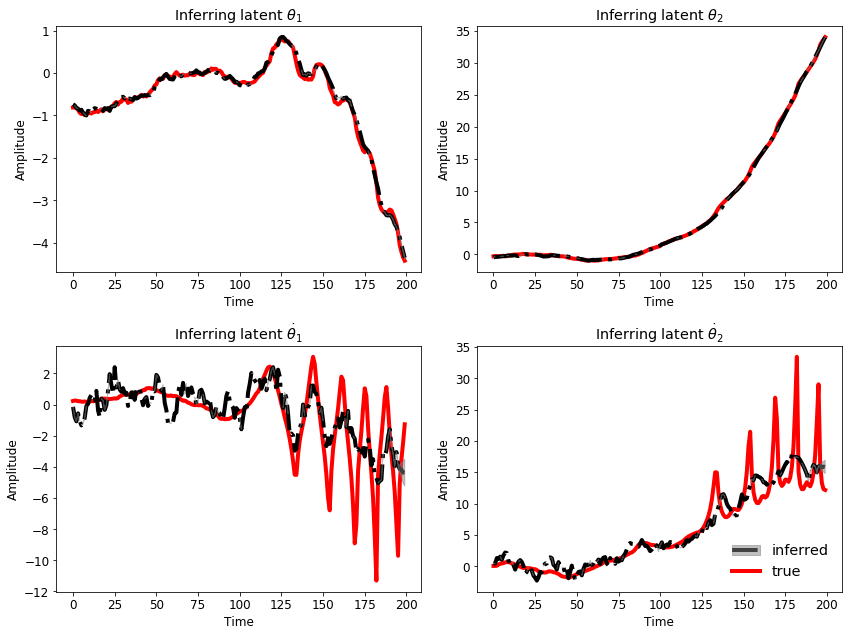

In [63]:
ind_in_batch = 6
# Note: label_list is a function of the dataset.
plot_inferred_traces(weighted_mean, weighted_var,
                     lat_data_np[:,2:,:], 
                     label_dict_vel["state"],
                    ind_in_batch, 
                     plot_folder + '/inferred_velocity_dyn.png')

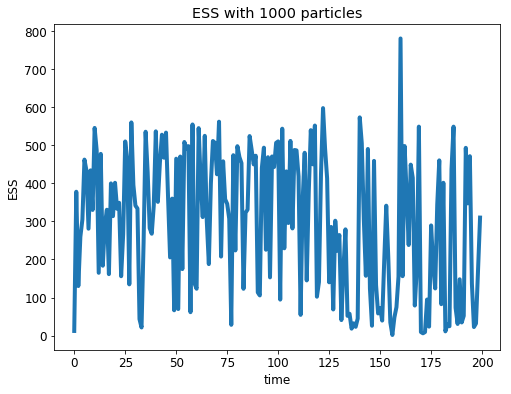

In [64]:
# plot ESS
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_1.png')

## step 3: infer torque dynamics from velocity dynamics means

In [65]:
# define new observations:
posterior_summary["smooth_mean"][:, :, 0].shape
obs_list = []
for i in range(posterior_summary["smooth_mean"].shape[-1]):
    obs_list.append(torch.tensor(posterior_summary["smooth_mean"][:, :, i]))

In [66]:
obs_list[-1].shape

torch.Size([16, 4])

In [67]:
# infer using torque model
inference_result_torque = infer_latents(torque_model, 
                                 obs_list, 
                                 num_particles)

run time for 200 timesteps, 16 batches, 1000 particles = 21.44


In [68]:
posterior_summary_torque = utils_summary.summarize_posterior(inference_result_torque)

In [69]:
weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary_torque["smooth_mean"],
    posterior_summary_torque["smooth_var"],
    logw=inference_result_torque["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None)

applying weighted average of 16 SMC samplers.


In [73]:
label_dict_torque["state"]

['$\\tau_1$',
 '$\\tau_2$',
 '$\\theta_1$',
 '$\\theta_2$',
 '$\\dot{\\theta}_1$',
 '$\\dot{\\theta}_2$']

ToDo: could run multiple indepndent times in previous step (velocity model) and in current step. also see what happens when you run multiple independent runs and average on full model. 

In [75]:
lat_data_np.shape

(16, 6, 200)

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


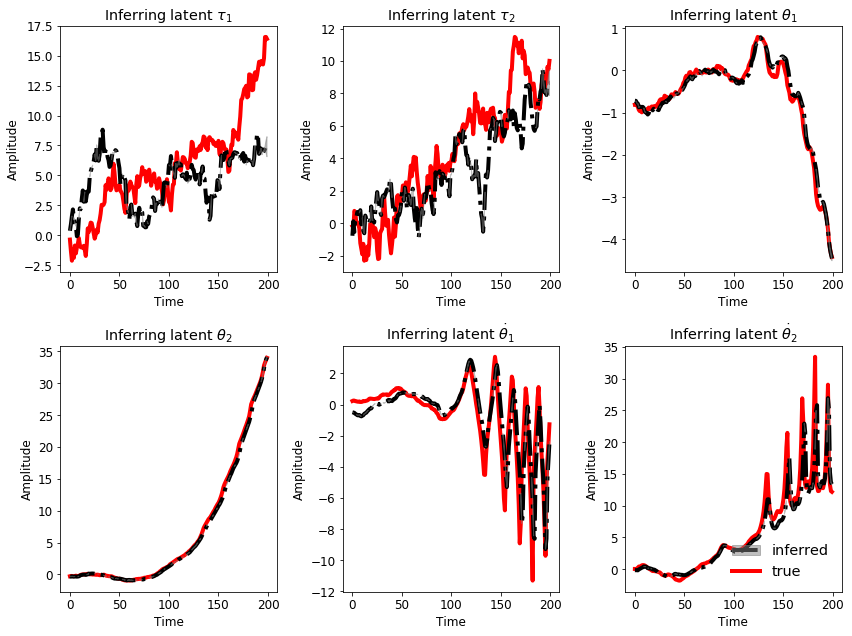

In [76]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/full_model_check_weighted.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(weighted_mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=weighted_mean[i,:],
    post_var=np.sqrt(weighted_var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

# ===========

In [77]:
# only for linear case!!
preds = np.zeros((dim_obs, num_timesteps))
preds_low = np.zeros((dim_obs, num_timesteps))
preds_high = np.zeros((dim_obs, num_timesteps))
for t in range(posterior_summary["smooth_mean"].shape[-1]):
    preds[:,t] = np.matmul(
                param_dict["C"],
                posterior_summary["smooth_mean"][ind_in_batch,:,t])
    preds_low[:,t] = np.matmul(
                param_dict["C"],
                posterior_summary["smooth_mean"][ind_in_batch,:,t]-
                np.sqrt(posterior_summary["smooth_var"][ind_in_batch,:,t]))
    preds_high[:,t] = np.matmul(
                param_dict["C"],
                posterior_summary["smooth_mean"][ind_in_batch,:,t]+
                np.sqrt(posterior_summary["smooth_var"][ind_in_batch,:,t]))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 6)

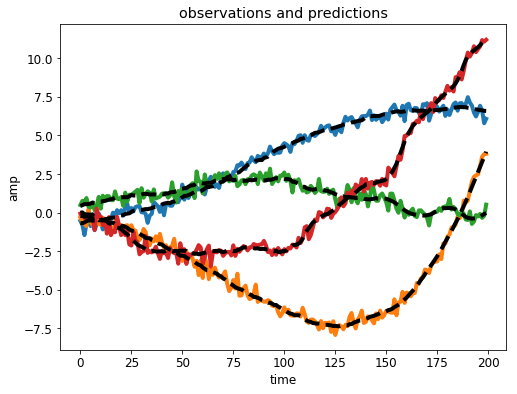

In [67]:
# only for linear case
plt.plot(sim_data_np[ind_in_batch,:,:].T);
plt.plot(preds[:,:].T, 'k--');
plt.xlabel('time')
plt.ylabel('amp')
#plt.legend(['obs', 'predictions'])
plt.title('observations and predictions')
plt.savefig(plot_folder +'/pred_vs_obs.png')

In [55]:
#multiple runs on the same data
"""this is an alternative approach that doesn't repeat the batch dimension."""
num_runs = 10
inference_result = []
for run in range(num_runs):
    inference_result.append(
        inference.infer(
                inference_algorithm='smc',
                observations=sim_observs, 
                initial=initial,
                transition=transition,
                emission=emission,
                proposal=proposal,
                num_particles=num_particles,
                return_log_weights=True,
            )
    )

In [80]:
posterior_summary = []
for run in range(num_runs):
    posterior_summary.append(
        utils_summary.summarize_posterior(
        inference_result[run])
    )
save_object(posterior_summary, 'post_summary_OP_10_runs')

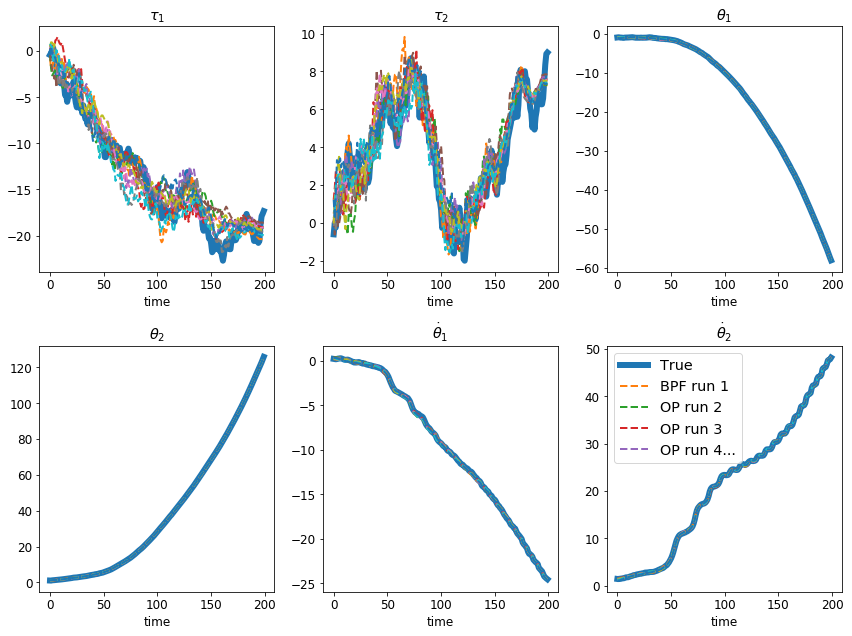

In [44]:
# first loop over latents 
# NOTE -- OP OR BPF? use currect legend and name
ind_in_batch = 1
fig, axs = plt.subplots(2, 3, figsize=(12, 9), 
                        sharey = False)
axs = axs.flatten()
for i in range(posterior_summary[0]["smooth_mean"].shape[1]):
    axs[i].plot(lat_data_np[ind_in_batch,i,:], linewidth = 6.0)
    axs[i].set_title(label_list[i])
    axs[i].set_xlabel("time")
    for run in range(num_runs):
        axs[i].plot(
            posterior_summary[run]["smooth_mean"][ind_in_batch,i,:],
            linestyle = 'dashed', linewidth = 2)
    axs[-1].legend(["True", "BPF run 1", 
                    "OP run 2", 
                    "OP run 3", 
                    "OP run 4..."])
fig.tight_layout()
plt.savefig(plot_folder+'/OP_multiple_runs.png')


In [65]:
sim_data.shape

torch.Size([10, 4, 200])

In [56]:
lat_data_np.shape

(64, 6, 200)

In [57]:
## if simulate all the way forward to coords.
#x_obs = sim_data_np[ind_in_batch, [0,2,4], :].T
#y_obs = sim_data_np[ind_in_batch, [1,3,5], :].T
## if simulate only to angles and velocities.
x_obs, y_obs = arm_utils.coords_from_params_mat(
   lat_data_np[ind_in_batch,2,:], 
    lat_data_np[ind_in_batch,3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
print(y_obs.shape)

(200, 3)


In [148]:
weighted_average.shape

(6, 200)

In [58]:
# TODO: make sure to input right params for learning
# this is the version for weighted average of BPFs
x_hat , y_hat = arm_utils.coords_from_params_mat(
   weighted_average[2,:], 
    weighted_average[3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
x_hat.shape

(200, 3)

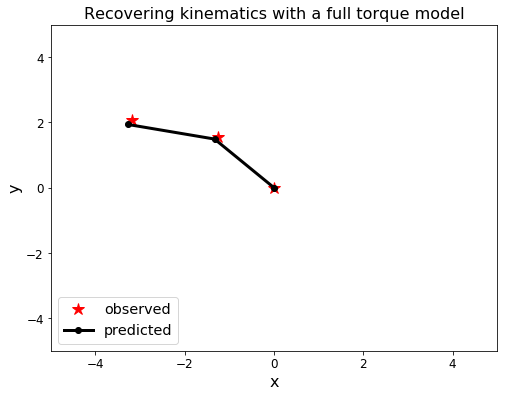

In [59]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             plot_folder+'/recover_dyn', 
                   "Recovering kinematics with a full torque model", 
                             x_hat.shape[0], inits_dict["L1"] + 
                             inits_dict["L2"] + 1)

In [70]:
# the optimal prop
def compute_average_ESS(posterior_summary_list, batch_size):
    mean_ess = np.zeros((len(posterior_summary_list), batch_size))
    for i in range(len(posterior_summary_list)): # i indicates run
        for b in range(batch_size): # b indicates batch of data (same across runs)
            mean_ess[i,b] = np.mean(posterior_summary_list[i]["ESS"][b,:]) # average over time
    return mean_ess

In [85]:
OP_summary = load_object('post_summary_OP_10_runs')
BPF_summary = load_object('post_summary_BPF_10_runs')
mean_ess_OP = compute_average_ESS(OP_summary, batch_size)
mean_ess_BPF = compute_average_ESS(BPF_summary, batch_size)

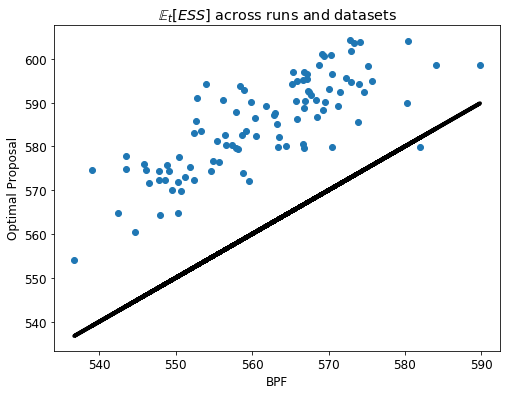

In [95]:
plt.scatter(mean_ess_BPF.flatten(),mean_ess_OP.flatten())
plt.plot(mean_ess_BPF.flatten(), mean_ess_BPF.flatten(), 'k')
plt.xlabel('BPF')
plt.ylabel('Optimal Proposal')
plt.title(r'$\mathbb{E}_{t}[ESS]$' + ' across runs and datasets')
plt.savefig(plot_folder +'/ESS_comparison.png')